<a href="https://colab.research.google.com/github/khaledlarbi/MVA_DL_TrashDetection/blob/main/pred_non_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Trashcan-data-set" data-toc-modified-id="Load-Trashcan-data-set-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Trashcan data set</a></span></li><li><span><a href="#Definition-of-the-Dataloader-and-the-model" data-toc-modified-id="Definition-of-the-Dataloader-and-the-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Definition of the Dataloader and the model</a></span></li><li><span><a href="#Definition-of-the-Faster-RCNN" data-toc-modified-id="Definition-of-the-Faster-RCNN-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Definition of the Faster RCNN</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></div>

This notebook aims to use a Faster RCNN from Imagenet pretrained Resnet50.

In [ ]:
!pip install pycocotools torch torchvision

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches #In order to draw the box ! (je sais pas pourquoi j'écris en anglais)
from torchvision import models
import torch.utils.data as data
from PIL import Image
import os
import os.path
import torchvision
import pycocotools
import copy
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
from torchvision import datasets
from torch.utils.data import DataLoader

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

CUDA_LAUNCH_BLOCKING=1.

## Load Trashcan data set 

In [ ]:
#In order to download the dataset
!wget "https://conservancy.umn.edu/bitstream/handle/11299/214865/dataset.zip?sequence=12&isAllowed=y"
!unzip "dataset.zip?sequence=12&isAllowed=y"

# The directory containing the source images
data_path = "dataset/instance_version/train"
valid_path = "dataset/instance_version/val"
# The path to the COCO labels JSON file
labels_path = "dataset/instance_version/instances_train_trashcan.json"
labels_test = "dataset/instance_version/instances_val_trashcan.json"

--2022-02-10 20:13:43--  https://conservancy.umn.edu/bitstream/handle/11299/214865/dataset.zip?sequence=12&isAllowed=y
Resolving conservancy.umn.edu (conservancy.umn.edu)... 128.101.122.105
Connecting to conservancy.umn.edu (conservancy.umn.edu)|128.101.122.105|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: 553029970 (527M) [application/zip]
Saving to: ‘dataset.zip?sequence=12&isAllowed=y’

dataset.zip?sequenc 100%[===================>] 527.41M  27.3MB/s    in 20s     

2022-02-10 20:14:04 (25.8 MB/s) - ‘dataset.zip?sequence=12&isAllowed=y’ saved [553029970/553029970]

Archive:  dataset.zip?sequence=12&isAllowed=y
replace dataset/README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from torchvision import models

resnet50_scratch = models.resnet50(pretrained=False)
image_torch = 800*torch.rand((1,3,800,800))
#We choose the place where we extracted the feature map in order to get H_feature * W_feature around 2400 (papers)
resnet50_features = nn.Sequential(*(list(resnet50_scratch.children())[:-3]))
resnet50_features(image_torch).shape

torch.Size([1, 1024, 50, 50])

# Download trained model

The weight are available : change link [here](https://www.dropbox.com/s/yovu0klcnal6y3j/scratch.pt?dl=0)

In [ ]:
#change link

--2022-02-10 20:16:37--  https://www.dropbox.com/s/yovu0klcnal6y3j/scratch.pt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.71.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.71.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/yovu0klcnal6y3j/scratch.pt [following]
--2022-02-10 20:16:37--  https://www.dropbox.com/s/dl/yovu0klcnal6y3j/scratch.pt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb8e2af7057a6336b4c02ea1ad0.dl.dropboxusercontent.com/cd/0/get/BfeRXe7XdrsB-2OUSQco-fnR5h54NIpeJpaUhkMVI33_vxJBh3Vvmy3CIdzHrkep6DRquBFhIw-U7Z3ttIZt0JPlSUXsU0aAMc8EQDtgto-wEARmTwi1FKkZtRiS4iLIbIoWtpeTj8_TL6fqBJjEpo4U/file?dl=1# [following]
--2022-02-10 20:16:38--  https://ucb8e2af7057a6336b4c02ea1ad0.dl.dropboxusercontent.com/cd/0/get/BfeRXe7XdrsB-2OUSQco-fnR5h54NIpeJpaUhkMVI33_vxJBh3Vvmy3CIdzHrkep6DRquBFhIw-U7Z3ttIZt0JPlSUXs

## Definition of the Dataloader and the model

In [ ]:
#Attention "bbox": [x,y,width,height]
class CocoDetection_diy_bis(data.Dataset) :
    """`MS Coco Detection <http://mscoco.org/dataset/#detections-challenge2016>`_ Dataset.

    Args:
        root (string): Root directory where images are downloaded to.
        annFile (string): Path to json annotation file.
        resize : (int,int) size of the images wanted 
    """

    def __init__(self, root, annFile, size):
        from pycocotools.coco import COCO
        self.root = root
        self.coco = COCO(annFile)
        self.total_ids = list(self.coco.imgs.keys())
        self.ids = [self.total_ids[j] for j in range(len(self.total_ids))]
        self.size = size
        self.transform = transforms.Compose([transforms.Resize(size), transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: Tuple (image, target). target is the object returned by ``coco.loadAnns``.
        """
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        target = coco.loadAnns(ann_ids)

        path = coco.loadImgs(img_id)[0]['file_name']

        # Resize des images :
        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        original_size = img.size
        img = self.transform(img)

        # Targets dict :
        targets = {'labels':[],'boxes':[], 'area':[]}

        for elem in target :  
          box = np.copy(elem['bbox'])
          box[0] *= self.size[0] / original_size[0]
          box[1] *= self.size[1] / original_size[1]
          box[2] *= self.size[0] / original_size[0]
          box[3] *= self.size[1] / original_size[1]
          
          new_box = np.copy(elem['bbox'])
          new_box[0] = box[0]
          new_box[1] = box[1] 
          new_box[2] = box[0] + (box[2])
          new_box[3] = box[1] + (box[3])
          area_computed = (new_box[3] - new_box[1])*(new_box[2] - new_box[0])
          targets['boxes'].append(new_box)
          targets['area'].append(area_computed)
          targets['labels'].append(elem['category_id']) # because 0 will be for background
        targets['labels'] = torch.from_numpy(np.array(targets["labels"])).to(torch.int64) 
        targets["iscrowd"] = torch.zeros(len(targets['area']))
        targets['area'] = torch.from_numpy(np.array(targets["area"]))
        if(len(targets["boxes"]) > 0):
            targets["boxes"] = torch.from_numpy(np.vstack(targets["boxes"]))
        else:
            targets["boxes"] = torch.Tensor([])
        
        return img, targets
        


    def __len__(self):
        return len(self.ids)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
instances_train = CocoDetection_diy_bis(root = data_path, annFile = labels_path, size=(224,224))
instances_train_dataloader = DataLoader(instances_train, batch_size=4, shuffle=True,collate_fn = collate_fn)

instances_valid = CocoDetection_diy_bis(root = valid_path, annFile = labels_test, size=(224,224))
instances_valid_dataloader = DataLoader(instances_valid, batch_size=4, shuffle=True,collate_fn = collate_fn)

loading annotations into memory...
Done (t=0.57s)
creating index...
index created!
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


## Definition of the Faster RCNN

We decided to take the same anchors size and ratios as proposed in the original paper except we had extra ones.

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

backbone = resnet50_features

backbone.out_channels = 1024


anchor_generator = AnchorGenerator(sizes=((4,8,16,32,64),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))


roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes= 23,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

## Loading the model

In [ ]:
model.eval()
model.to(device)
#Add weights
model.load_state_dict(torch.load("non_scratch.pt",map_location = torch.device("cpu")))

<All keys matched successfully>

## Evaluation

In [ ]:
def pictures_and_boxes(image_tensor, boxes, size):
    trans = transforms.Compose([transforms.Resize(size), transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)])
    img = transforms.functional.to_pil_image(trans(image_tensor.squeeze()))
    #draw = ImageDraw.Draw(img)
    fig, ax = plt.subplots()
    plt.imshow(img)
    for box in boxes.tolist():
        #box = correction(box)
        #rect = patches.Rectangle((box[0],box[1]) , box[2] , box[3], linewidth=1, edgecolor='r', facecolor='none')
        rect = patches.Rectangle((box[0],box[1]) , (box[2] - box[0]) ,(box[3] - box[1]), linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    return(img)

1
7
8
14
18


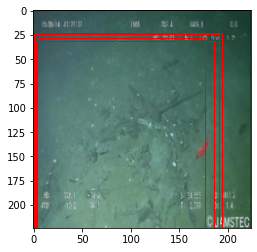

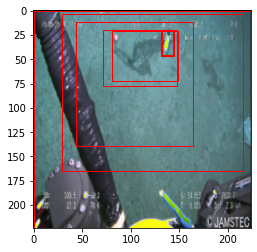

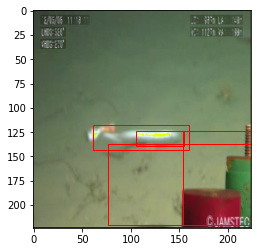

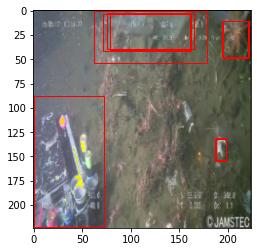

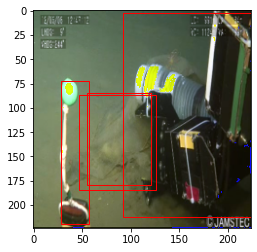

In [ ]:
for i in [1,7,8,14,18]:
    model.eval()
    print(i)
    pred = model(instances_valid[i][0].unsqueeze(0))
    pictures_and_boxes(instances_valid[i][0], pred[0]["boxes"], (224,224))

In [ ]:
 model(instances_valid[2][0].unsqueeze(0))

[{'boxes': tensor([[1.4594e+02, 2.4033e+01, 2.2039e+02, 1.2937e+02],
          [1.3072e+02, 2.3531e+01, 2.2400e+02, 1.3324e+02],
          [1.4143e+00, 7.7592e+00, 1.6548e+02, 1.3245e+02],
          [0.0000e+00, 7.3539e+00, 1.5489e+02, 1.1768e+02],
          [1.1658e+02, 1.3634e+02, 2.1136e+02, 1.9881e+02],
          [1.2770e-01, 6.8260e+00, 1.6422e+02, 1.3402e+02],
          [1.1551e+02, 1.3438e+02, 2.0201e+02, 2.0334e+02],
          [3.3234e+00, 1.2223e+01, 1.5745e+02, 1.2914e+02],
          [1.4571e+02, 2.9997e+01, 2.2168e+02, 1.3350e+02],
          [1.4790e+02, 2.5936e+01, 2.2382e+02, 1.3085e+02]],
         grad_fn=<StackBackward0>),
  'labels': tensor([ 2, 22, 17, 19, 22, 20,  2, 12,  6,  4]),
  'scores': tensor([0.7152, 0.2086, 0.1743, 0.1701, 0.1037, 0.0884, 0.0881, 0.0847, 0.0650,
          0.0589], grad_fn=<IndexBackward0>)}]